In [2]:
import pandas as pd
from dataset_manager import DatasetManager

# 1 - Load de dados

In [3]:
dataset_path = "./datasets"
manager = DatasetManager(dataset_path)
manager.show_datasets()

,description,format,identifier,local_source,source
0,Média de alunos por turmas em escolas e creche...,zip xls,media_alunos_2008,./data/media_alunos_2008,http://download.inep.gov.br/informacoes_estati...
1,Quantidade de creches e pré-escolas cujas obra...,json,construcao_creche,./data/construcao_creche.json,http://api.pgi.gov.br/api/1/serie/2620.json
2,Quantidade de projetos para a construção de cr...,json,aprovacao_construcao_creche,./data/aprovacao_construcao_creche.json,http://api.pgi.gov.br/api/1/serie/2555.json
3,Valor do investimento para a construção das cr...,json,investimento_em_construcao_creche,./data/investimento_em_construcao_creche.json,http://api.pgi.gov.br/api/1/serie/1703.json
4,Média de alunos por turmas em escolas e creche...,zip xls,media_alunos_2010,./data/media_alunos_2010,http://download.inep.gov.br/informacoes_estati...
5,Média de alunos por turmas em escolas e creche...,zip xls,media_alunos_2009,./data/media_alunos_2009,http://download.inep.gov.br/informacoes_estati...


In [4]:
manager.prepare_dataset()

04-29 21:34 - DatasetManager - prepare_dataset - INFO - Preparing media_alunos_2008 ...
04-29 21:34 - DataSource - download - DEBUG - media_alunos_2008 is cached. Skip Download.
04-29 21:34 - DataSource - unzip_file - DEBUG - local zip file of {} do not existes.
04-29 21:34 - DatasetManager - prepare_dataset - INFO - media_alunos_2008 is ready to use!
04-29 21:34 - DatasetManager - prepare_dataset - INFO - Preparing construcao_creche ...
04-29 21:34 - DataSource - download - DEBUG - construcao_creche is cached. Skip Download.
04-29 21:34 - DataSource - unzip_file - DEBUG - local zip file of {} do not existes.
04-29 21:34 - DatasetManager - prepare_dataset - INFO - construcao_creche is ready to use!
04-29 21:34 - DatasetManager - prepare_dataset - INFO - Preparing aprovacao_construcao_creche ...
04-29 21:34 - DataSource - download - DEBUG - aprovacao_construcao_creche is cached. Skip Download.
04-29 21:34 - DataSource - unzip_file - DEBUG - local zip file of {} do not existes.
04-29 21:

# 2 - Ler dataset de media de alunos

In [5]:
datasets_keys = [x for x in manager.get_datasets() if x.startswith("media_alunos")]

In [6]:
def read_dataset(identifier):
    datasets = manager.load_as_pandas(identifier, sheet_name=[0,1])
    return pd.concat(datasets)

In [7]:
alunos_2008 = read_dataset(datasets_keys[0])
alunos_2009 = read_dataset(datasets_keys[1])
alunos_2010 = read_dataset(datasets_keys[2])

In [8]:
alunos = pd.concat([alunos_2008,alunos_2009, alunos_2010])

# 3 - Renomear colunas

In [9]:
def renamed(df):
    df_renamed = df.rename(
        columns={
            "Unnamed: 0" : "ano",
            "Ministério da Educação":"regiao",
            "Unnamed: 2":"estado",
            "Unnamed: 3" : "cod_municipio",
            "Unnamed: 4" : "municipio",
            "Unnamed: 5" : "localizacao",
            "Unnamed: 6" : "rede",
            "Unnamed: 7" : "media_alunos_etapa",
            "Unnamed: 8" : "rede",
            "Unnamed: 7" : "educacao_infantil - total",
            "Unnamed: 8" : "educacao_infantil - creche",
            "Unnamed: 9" : "educacao_infantil - pre-escola",
            "Unnamed: 10" : "ensino_fundamental - total",
            "Unnamed: 11" : "ensino_fundamental - anos_inic",
            "Unnamed: 12" : "ensino_fundamental - anos_finais",
            "Unnamed: 13" : "ensino_fundamental - 1ano",
            "Unnamed: 14" : "ensino_fundamental - 2ano",
            "Unnamed: 15" : "ensino_fundamental - 3ano",
            "Unnamed: 16" : "ensino_fundamental - 4ano",
            "Unnamed: 17" : "ensino_fundamental - 5ano",
            "Unnamed: 18" : "ensino_fundamental - 6ano",
            "Unnamed: 19" : "ensino_fundamental - 7ano",
            "Unnamed: 20" : "ensino_fundamental - 8ano",
            "Unnamed: 21" : "ensino_fundamental - 9ano",
            "Unnamed: 22" : "turmas_unificadas",
            "Unnamed: 23" : "ensino_medio - total_media",
            "Unnamed: 24" : "ensino_medio - 1ano",
            "Unnamed: 25" : "ensino_medio - 2ano",
            "Unnamed: 26" : "ensino_medio - 3ano",
            "Unnamed: 27" : "ensino_medio - 4ano",
            "Unnamed: 28" : "medio_nao_seriado"
        }
    )
    return df_renamed

In [10]:
alunos_renamed = renamed(alunos)

# 4 - Filtro

In [11]:
def filter_df(df):
    df_renamed_filtred = df[
        (~df["municipio"].isnull()) & 
        (df["ano"] != "Ano")]
    
    df_clean = df_renamed_filtred[["ano",
                        "estado",
                        "municipio",
                        "localizacao",
                        "rede",
                        "educacao_infantil - creche",
                        "educacao_infantil - pre-escola"]]
    
    return df_clean

In [12]:
alunos_filtered = filter_df(alunos_renamed)

## Filtro alunos apenas no `Rio de Janeiro`

In [13]:
def city_filter(city_name, state_name):
    alunos = alunos_filtered[ (alunos_filtered["municipio"] == city_name) &
                              (alunos_filtered["estado"] == state_name)]
    return alunos[alunos["localizacao"] == "Total"]

In [14]:
alunos_rj = city_filter("RIO DE JANEIRO", "RJ")

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style("whitegrid")

04-29 21:36 - matplotlib - wrapper - DEBUG - CACHEDIR=/home/bouchardet/.cache/matplotlib
04-29 21:36 - matplotlib.font_manager - <module> - DEBUG - Using fontManager instance from /home/bouchardet/.cache/matplotlib/fontlist-v300.json
04-29 21:36 - matplotlib.pyplot - switch_backend - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.
04-29 21:36 - matplotlib.pyplot - switch_backend - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


## 5 -  Media de alunos em turmas nas criches da cidade do `Rio De Janeiro`

04-29 21:36 - matplotlib.axes._base - _update_title_position - DEBUG - update_title_pos
04-29 21:36 - matplotlib.font_manager - _findfont_cached - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000.
04-29 21:36 - matplotlib.font_manager - _findfont_cached - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000.
04-29 21:36 - matplotlib.axes._base - _update_title_position - DEBUG - update_title_pos
04-29 21:36 - matplotlib.axes._base - _update_title_position - DEBUG - update_title_pos
04-29 21:36 - matplotlib.axes._base - _update_title_position - DEBUG - u

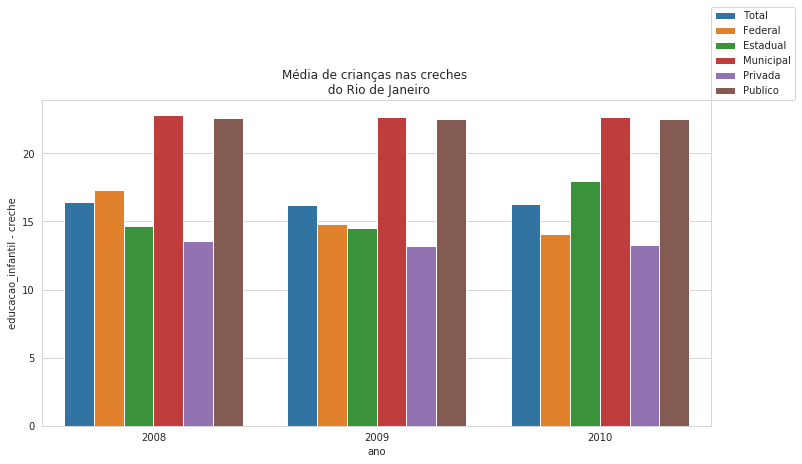

In [16]:
plt.subplots(figsize=(12,6))
plt.title("Média de crianças nas creches \n do Rio de Janeiro")

sns.barplot(x="ano",
            y="educacao_infantil - creche",
            hue="rede",
            data=alunos_rj,
            ci=None)
plt.legend(loc=[1,1])


# 6 - Comparação entreo o `Rio de Janeiro` e outras cidades

In [17]:
def clean_alunos_filtered_by_year(year, state=None, city=None):

    base_filter = ((alunos_filtered["educacao_infantil - creche"] != "--") &
                                       (alunos_filtered["rede"] == "Municipal") &
                                       (alunos_filtered["localizacao"] == "Total"))
    if state:
        base_filter = base_filter & (alunos_filtered["estado"] == state)
    
    if year:
        base_filter = base_filter & (alunos_filtered["ano"] == year)
    
    if city:
        base_filter = base_filter & (alunos_filtered["municipio"] == city)

    return alunos_filtered[base_filter]

In [66]:
def alunos_rank(year, state=None):
    alunos_rj_year = clean_alunos_filtered_by_year(year,state)
    alunos_rj_year.loc[:,'rank'] = alunos_rj_year["educacao_infantil - creche"].rank(ascending = False) 
    return alunos_rj_year

In [67]:
def rj_rank(year, state = None):
    all_year = alunos_rank(year, state)
    return all_year[all_year["municipio"] == "RIO DE JANEIRO"]["rank"][0]

/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/bouchardet/Projects/data_science/.env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


04-29 22:13 - matplotlib.axes._base - _update_title_position - DEBUG - update_title_pos
04-29 22:13 - matplotlib.axes._base - _update_title_position - DEBUG - update_title_pos
04-29 22:13 - matplotlib.axes._base - _update_title_position - DEBUG - update_title_pos
04-29 22:13 - matplotlib.axes._base - _update_title_position - DEBUG - update_title_pos
04-29 22:13 - matplotlib.axes._base - _update_title_position - DEBUG - update_title_pos


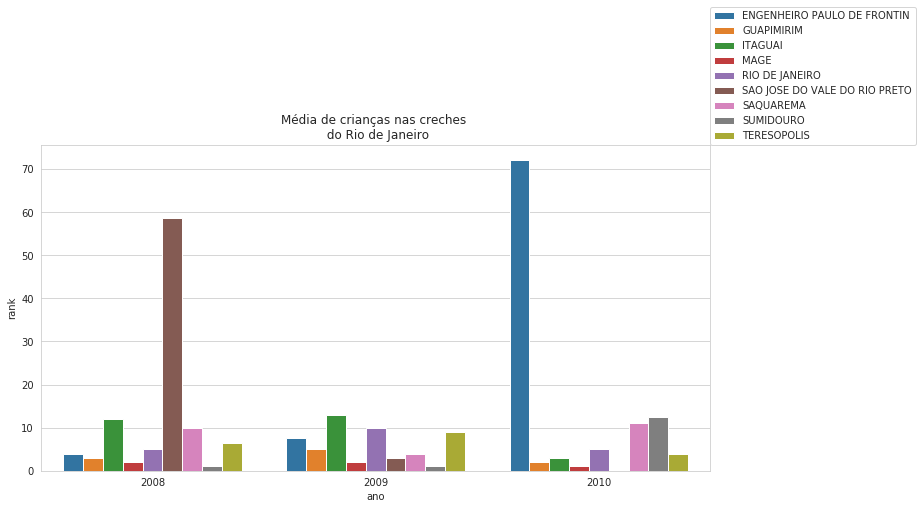

In [79]:
all_cities = pd.concat([alunos_rank(2008,"RJ"),
                        alunos_rank(2009,"RJ"),
                        alunos_rank(2010,"RJ")])

top_cities = all_cities[all_cities["rank"]<=5]["municipio"].unique()
all_cities  = all_cities[all_cities['municipio'].isin(top_cities)]


plt.subplots(figsize=(12,6))
plt.title("Média de crianças nas creches \n do Rio de Janeiro")


sns.barplot(x='ano', y='rank', hue='municipio', data=all_cities)
plt.legend(loc=[1,1])

In [52]:
sns.lineplot?